In [4]:
#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

import numpy as np
import pandas as pd  
import gensim#For topic modeling
import lucem_illud

In [1]:
now_df = pd.read_table('data/sample.txt' ,header=0, encoding='gb2312', sep=',') 
now_df

,id,text,month,year
0,1705816,"For those of us who have not known war , the ...",11,10
1,4512620,"Kazi Khaleed Ashraf ONCE upon a time , Dhak...",3,10
2,1448476,There is a myth in wide circulation that the ...,4,10
3,1490802,Please turn on JavaScript . Media requires Ja...,5,10
4,1647381,Image caption The death of Mono Jojoy could c...,9,10
...,...,...,...,...
45425,31034526,Can an academic study also double up as a riv...,6,19
45426,50673735,"Glasgow Southside , where Nicola Sturgeon is ...",5,19
45427,31262587,"Rabbi Joachim Prinz , second from the left , ...",9,19
45428,50662844,The global rate of species extinction is ten ...,5,19


In [2]:
now_df = now_df.dropna(axis = 0)

In [3]:
#initialize
nowTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, 
                                                                  min_df=3, stop_words='english', norm='l2')
#train
nowTFVects = nowTFVectorizer.fit_transform(now_df['text'])
print(nowTFVects.shape)

(45429, 1000)


In [4]:
now_df['tokenized_text'] = now_df['text'].apply(lambda x: lucem_illud.word_tokenize(x))
now_df['normalized_tokens'] = now_df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

KeyboardInterrupt: 

In [ ]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

now_df['reduced_tokens'] = now_df['normalized_tokens'].apply(lambda x: dropMissing(x, nowTFVectorizer.vocabulary_.keys()))

In [ ]:
now_df

In [26]:
dictionary = gensim.corpora.Dictionary(now_df['reduced_tokens'])

In [27]:
corpus = [dictionary.doc2bow(text) for text in now_df['reduced_tokens']]

In [28]:
gensim.corpora.MmCorpus.serialize('data/now.mm', corpus)
nowmm = gensim.corpora.MmCorpus('data/now.mm')

In [29]:
nowlda = gensim.models.ldamodel.LdaModel(corpus=nowmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [30]:
now1Bow = dictionary.doc2bow(now_df['reduced_tokens'][0])
now1lda = nowlda[now1Bow]

In [31]:
print("The topics of the text: {}".format(now_df['id'][0]))
print("are: {}".format(now1lda))

The topics of the text: 1705816
are: [(0, 0.17430049), (2, 0.09471043), (3, 0.0668286), (4, 0.117352165), (6, 0.019002883), (8, 0.52604234)]


In [41]:
ldaDF = pandas.DataFrame({
        'id' : now_df['id'],
        'year' : now_df['year'],
        'topics' : [nowlda[dictionary.doc2bow(l)] for l in now_df['reduced_tokens']]
    })

In [42]:
ldaDF

,id,year,topics
0,1705816,10,"[(0, 0.17717889), (2, 0.093628466), (3, 0.0695..."
1,4512620,10,"[(0, 0.08159034), (1, 0.3966306), (4, 0.236846..."
2,1448476,10,"[(1, 0.04726045), (2, 0.55008733), (4, 0.39872..."
3,1490802,10,"[(2, 0.2329995), (3, 0.09909913), (5, 0.250480..."
4,1647381,10,"[(0, 0.6065858), (1, 0.09624033), (5, 0.292426..."
...,...,...,...
45425,31034526,19,"[(0, 0.3627134), (1, 0.079046376), (3, 0.11854..."
45426,50673735,19,"[(5, 0.13465354), (8, 0.5176997), (9, 0.344715..."
45427,31262587,19,"[(0, 0.32797137), (2, 0.17207082), (4, 0.37280..."
45428,50662844,19,"[(0, 0.16285183), (1, 0.3746136), (2, 0.146622..."


In [43]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(nowlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(nowlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF.head(10)

,id,year,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,1705816,10,"[(0, 0.17717889), (2, 0.093628466), (3, 0.0695...",0.177179,0.000000,0.093628,0.069540,0.135945,0.000000,0.000000,0.000000,0.521584,0.000000
1,4512620,10,"[(0, 0.08159034), (1, 0.3966306), (4, 0.236846...",0.081590,0.396631,0.000000,0.000000,0.236846,0.281470,0.000000,0.000000,0.000000,0.000000
2,1448476,10,"[(1, 0.04726045), (2, 0.55008733), (4, 0.39872...",0.000000,0.047260,0.550087,0.000000,0.398727,0.000000,0.000000,0.000000,0.000000,0.000000
3,1490802,10,"[(2, 0.2329995), (3, 0.09909913), (5, 0.250480...",0.000000,0.000000,0.233000,0.099099,0.000000,0.250480,0.000000,0.000000,0.000000,0.403130
4,1647381,10,"[(0, 0.6065858), (1, 0.09624033), (5, 0.292426...",0.606586,0.096240,0.000000,0.000000,0.000000,0.292427,0.000000,0.000000,0.000000,0.000000
5,1513952,10,"[(0, 0.10036107), (4, 0.6350719), (5, 0.032975...",0.100361,0.000000,0.000000,0.000000,0.635072,0.032975,0.166377,0.000000,0.000000,0.058912
6,1698792,10,"[(0, 0.8850704), (2, 0.074065134), (4, 0.02928...",0.885070,0.000000,0.074065,0.000000,0.029281,0.000000,0.011201,0.000000,0.000000,0.000000
7,1346268,10,"[(2, 0.26740414), (3, 0.22990528), (4, 0.42334...",0.000000,0.000000,0.267404,0.229905,0.423349,0.070669,0.000000,0.000000,0.000000,0.000000
8,1745872,10,"[(0, 0.02059669), (3, 0.67279494), (5, 0.03813...",0.020597,0.000000,0.000000,0.672795,0.000000,0.038139,0.199426,0.019266,0.000000,0.049183
9,4513686,10,"[(1, 0.23998596), (2, 0.031135391), (5, 0.7191...",0.000000,0.239986,0.031135,0.000000,0.000000,0.719193,0.000000,0.000000,0.000000,0.000000


In [55]:
ldaDF_10 = ldaDF[ldaDF["year"] == 10][['topic_%d' %x for x in range(10)]]
ldaDF_10
ldaDFVisN = ldaDF[ldaDF["year"] == 10][['id']]
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values

In [65]:
topicsDict = {}
for topicNum in range(nowlda.num_topics):
    topicWords = [w for w, p in nowlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,state,development,party,right,think,say,woman,south,tax,school
1,political,business,election,india,trump,president,man,africa,income,child
2,power,service,policy,law,know,mr,gender,african,rate,education
3,right,need,trade,human,thing,city,work,black,say,student
4,social,sector,economic,social,work,state,say,land,cent,health
5,democracy,work,china,pakistan,want,day,female,anc,high,university
6,society,economic,political,society,way,minister,film,white,pay,say
7,nigeria,growth,vote,indian,come,house,equality,africans,low,work
8,war,public,climate,court,look,tell,day,say,increase,high
9,movement,provide,change,case,good,member,violence,president,wealth,community


# Dynamic topic modeling

See [this tutorial](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb).

In [1]:
%store -r now_df

In [2]:
corpus= []
docs_per_time_slice = [0] * 10

for i in range(len(now_df)):   
    try:
        corpus.append(now_df['reduced_tokens'][i])
        docs_per_time_slice[int(now_df['year'][i])-10] += 1    
    except:
        continue

        
# just a check if the counts are correctly added
if np.sum(docs_per_time_slice) != len(corpus):
    print(np.sum(docs_per_time_slice), len(corpus))

In [5]:
dictionary = gensim.corpora.Dictionary(corpus)

In [6]:
now_corpus = [dictionary.doc2bow(text) for text in corpus]

In [7]:
gensim.corpora.MmCorpus.serialize('data/dynamic_tm.mm', now_corpus)
nowcorpus = gensim.corpora.MmCorpus('data/dynamic_tm.mm')

In [8]:
from gensim.models import ldaseqmodel

In [10]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=now_corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=9)

C:\Users\xiche\anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [14]:
%store ldaseq

Stored 'ldaseq' (LdaSeqModel)


In [52]:
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.corpora import Dictionary, bleicorpus
import pyLDAvis

In [60]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=0, corpus=now_corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

C:\Users\xiche\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=1, corpus=now_corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

C:\Users\xiche\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=2, corpus=now_corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

C:\Users\xiche\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=3, corpus=now_corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

C:\Users\xiche\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=4, corpus=now_corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

C:\Users\xiche\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=5, corpus=now_corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

C:\Users\xiche\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=6, corpus=now_corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

C:\Users\xiche\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=7, corpus=now_corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

C:\Users\xiche\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=8, corpus=now_corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

C:\Users\xiche\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=9, corpus=now_corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

C:\Users\xiche\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


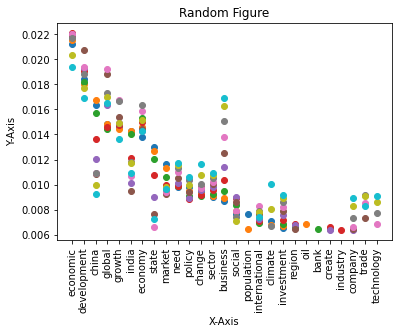

In [51]:
import matplotlib.pyplot as plt
from math import log

for i in range(10):
    plt.scatter(*zip(*ldaseq.print_topics(time=i)[0]))
#plt.scatter(*zip(*ldaseq.print_topics(time=1)[0]))
plt.xticks(rotation=90)
plt.title('Random Figure')
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.show()

In [38]:
topic0_dtm = pandas.DataFrame()

for i in range(10):
    topic0_dtm[i] = ldaseq.print_topics(time=i)[0]

topic0_dtm

,0,1,2,3,4,5,6,7,8,9
0,"(economic, 0.021245940057621652)","(economic, 0.021499479761286036)","(economic, 0.021913096673165867)","(economic, 0.02212476139432596)","(economic, 0.022012784621674795)","(economic, 0.021848424667898058)","(economic, 0.02204915383438869)","(economic, 0.02171305228082624)","(economic, 0.020317142447846753)","(economic, 0.019366917287167905)"
1,"(development, 0.018425150327460834)","(development, 0.01805631487913326)","(development, 0.018209613299805503)","(development, 0.01907787900705507)","(development, 0.01933928655244908)","(development, 0.02070776036913864)","(development, 0.019361423806181718)","(development, 0.018855015328154832)","(development, 0.017668536313092755)","(development, 0.016916015757704742)"
2,"(china, 0.016388998985970907)","(china, 0.0167777887802238)","(china, 0.015678281160915325)","(economy, 0.015025685082554911)","(global, 0.016342404407690157)","(global, 0.018832969927036404)","(global, 0.019183924923432363)","(global, 0.017318890821429053)","(global, 0.016971273553981092)","(business, 0.016906880678950468)"
3,"(global, 0.014826620930828743)","(global, 0.0148263759307593)","(economy, 0.015291055556128906)","(growth, 0.014787078775174768)","(growth, 0.014898170172572164)","(growth, 0.015398319942046816)","(growth, 0.01674749542415727)","(growth, 0.016637182586245133)","(business, 0.016266516418984422)","(global, 0.01653897594307057)"
4,"(growth, 0.014597487976069403)","(economy, 0.014632536914300083)","(growth, 0.014842725135962333)","(global, 0.014583932388792822)","(economy, 0.014266664296272524)","(economy, 0.014423782409315905)","(economy, 0.015902937666338577)","(economy, 0.016388409519456387)","(economy, 0.015174760786476825)","(economy, 0.014275882212426882)"
5,"(india, 0.014283663193053317)","(growth, 0.014444123554438033)","(global, 0.014415217016542567)","(china, 0.013658998208187953)","(china, 0.012046937540506236)","(business, 0.01255063001243652)","(business, 0.013769674226557824)","(business, 0.015105467023618641)","(growth, 0.014877024772723922)","(growth, 0.013623722959666615)"
6,"(economy, 0.013810055639709337)","(india, 0.014316797930150896)","(india, 0.014061760498780596)","(india, 0.01216197039837876)","(business, 0.011391731419918016)","(china, 0.010872240372281074)","(need, 0.010982327977191437)","(india, 0.011789133899118216)","(india, 0.011731889661130401)","(need, 0.011689724971680674)"
7,"(state, 0.013014847684127095)","(state, 0.012667478121870721)","(state, 0.012038788718996093)","(state, 0.010772770255911675)","(india, 0.010115905337916415)","(need, 0.010520899620642501)","(china, 0.01091517229064778)","(need, 0.011352487480049172)","(need, 0.011576772010430844)","(change, 0.011665248746647896)"
8,"(market, 0.011662197738927215)","(market, 0.011296898556181382)","(market, 0.010646790034563928)","(business, 0.010340514572071063)","(need, 0.010098377480634893)","(sector, 0.010048821688817681)","(india, 0.01071984856996989)","(china, 0.010922419156022383)","(sector, 0.010792905507105894)","(india, 0.010952488828451326)"
9,"(need, 0.00983061852722296)","(need, 0.009858644111896311)","(need, 0.009872764502188078)","(market, 0.009963787381880087)","(sector, 0.009815537537215728)","(change, 0.009819243913603736)","(policy, 0.010462894334340727)","(sector, 0.010509693818646939)","(change, 0.010739053957184688)","(sector, 0.010952346732583095)"


In [39]:
topic1_dtm = pandas.DataFrame()

for i in range(10):
    topic1_dtm[i] = ldaseq.print_topics(time=i)[1]

topic1_dtm

,0,1,2,3,4,5,6,7,8,9
0,"(income, 0.03619909463735368)","(income, 0.03789453079283068)","(income, 0.039466605189428385)","(income, 0.03760514969277886)","(income, 0.03697314806624585)","(income, 0.03316883614733184)","(tax, 0.03159263088049245)","(tax, 0.032810052366931686)","(tax, 0.029371996808637117)","(tax, 0.029401862116597594)"
1,"(tax, 0.023666904433784053)","(tax, 0.02197455275159482)","(tax, 0.019250622520164865)","(wage, 0.01864123727787111)","(tax, 0.019117587013962874)","(tax, 0.024247588869039976)","(income, 0.027945073342285763)","(income, 0.029940337932576604)","(income, 0.02869077003939337)","(income, 0.028382916020979514)"
2,"(pay, 0.021868500802581667)","(pay, 0.019711804157302438)","(pay, 0.018208527817059075)","(tax, 0.017882229323797707)","(wage, 0.01881888781063419)","(pay, 0.018389198332273128)","(pay, 0.0194782871299957)","(pay, 0.018187281897601233)","(rate, 0.017935849576221446)","(rate, 0.019550437023047807)"
3,"(high, 0.017322120796630043)","(high, 0.017534414944344125)","(high, 0.017546776569430114)","(pay, 0.01743294358998447)","(pay, 0.016842699290218394)","(wage, 0.017179216282197412)","(rate, 0.018101487228007744)","(rate, 0.018072613143711603)","(pay, 0.017723108742490924)","(pay, 0.018253339388276356)"
4,"(rate, 0.01694843457262373)","(rate, 0.01690655965252344)","(wage, 0.016747108161340164)","(high, 0.017285753467573776)","(wealth, 0.01666673762977205)","(rate, 0.017004222331101077)","(low, 0.015709840961484693)","(cent, 0.017585812360558485)","(high, 0.017056256460040876)","(high, 0.017314034121660722)"
5,"(increase, 0.01624146094624841)","(increase, 0.015357598434183422)","(rate, 0.01670309477003577)","(rate, 0.016570345289220703)","(rate, 0.016632969023972564)","(low, 0.015830869162858804)","(high, 0.015115440836348509)","(high, 0.016056955965108775)","(increase, 0.016788196512339714)","(low, 0.016588269173005283)"
6,"(percent, 0.01546928999335719)","(percent, 0.015323621924597844)","(low, 0.015174446141635623)","(low, 0.015712601940810863)","(high, 0.016494895566682096)","(high, 0.015536483162137486)","(increase, 0.0150752946799875)","(low, 0.015880676995691147)","(cent, 0.016691348840780777)","(increase, 0.016327422982889125)"
7,"(rich, 0.014882631430446937)","(rich, 0.015038125255250761)","(job, 0.014835123792897354)","(cent, 0.01522911830834839)","(low, 0.015834183153463306)","(wealth, 0.014331673016459085)","(wage, 0.014940446134656796)","(increase, 0.01580981974069818)","(low, 0.01641153978938125)","(wage, 0.014222221354812844)"
8,"(low, 0.013819818340029278)","(wage, 0.014656992850239773)","(cent, 0.014694375815697202)","(job, 0.014595888796638663)","(job, 0.014026969694949895)","(increase, 0.014327052575197282)","(cent, 0.014474299427479501)","(wage, 0.014042686763104476)","(wage, 0.014427203107965973)","(cent, 0.01421034985324462)"
9,"(poor, 0.013779858832249392)","(low, 0.014366125661308118)","(increase, 0.014409537174303684)","(increase, 0.013985434579401972)","(increase, 0.013982720863618216)","(job, 0.013917064328644098)","(job, 0.012464047764877074)","(wealth, 0.012753374224770575)","(wealth, 0.012963452617852143)","(wealth, 0.013456210315916992)"


In [40]:
topic2_dtm = pandas.DataFrame()

for i in range(10):
    topic2_dtm[i] = ldaseq.print_topics(time=i)[2]

topic2_dtm

,0,1,2,3,4,5,6,7,8,9
0,"(party, 0.030053116324341565)","(party, 0.03061989613774938)","(party, 0.03164623388773792)","(party, 0.033191723243329606)","(party, 0.035294098497930394)","(party, 0.03775151343386313)","(party, 0.039954540234040936)","(party, 0.041326575702983544)","(party, 0.042523871346818475)","(party, 0.04354562020931746)"
1,"(political, 0.02525807089225301)","(political, 0.026303566871376752)","(political, 0.028604743266650558)","(political, 0.031011318300900762)","(political, 0.030883036960053175)","(political, 0.027169455002059514)","(political, 0.0228360763776977)","(political, 0.02492184801813262)","(political, 0.026848958925148672)","(election, 0.024858398126912852)"
2,"(union, 0.0234499068743583)","(union, 0.023522963657633664)","(union, 0.023118060514080843)","(union, 0.0218040947837377)","(union, 0.019388654893237572)","(election, 0.018424995798778723)","(election, 0.020672946453547118)","(election, 0.022396716514634055)","(election, 0.023809393508528377)","(political, 0.024530395173414956)"
3,"(movement, 0.021516218799424683)","(movement, 0.022893879742481662)","(movement, 0.019347906577271517)","(movement, 0.014780267524960623)","(election, 0.016165230205949635)","(vote, 0.017743083015075718)","(vote, 0.019202896440638495)","(vote, 0.020009082520988153)","(vote, 0.02065036080234182)","(vote, 0.021180329112015724)"
4,"(social, 0.0147901290342035)","(social, 0.014741821832843118)","(class, 0.014668247713254742)","(vote, 0.014694885477512637)","(vote, 0.016110477398294666)","(union, 0.016582703381772815)","(labour, 0.016379884913794752)","(labour, 0.016936437810971282)","(minister, 0.015787735759622886)","(minister, 0.01671444519672962)"
5,"(right, 0.01420982213479504)","(right, 0.01377518359356291)","(social, 0.014292215019403766)","(class, 0.014459575542931508)","(labour, 0.012902820907666692)","(labour, 0.015111349116546787)","(union, 0.014107221808301465)","(leader, 0.01379903004814065)","(leader, 0.014277992449111248)","(leader, 0.014058762341701876)"
6,"(state, 0.013751014856587562)","(work, 0.013165244119533799)","(work, 0.013921014676621296)","(election, 0.014311971221403902)","(leave, 0.012308781133513615)","(leave, 0.012854862593874928)","(leave, 0.013522903574671256)","(leave, 0.012893990526768645)","(labour, 0.013625087777702057)","(union, 0.012320099548961346)"
7,"(class, 0.0133758777371771)","(vote, 0.012980364408272552)","(vote, 0.013653750686208775)","(social, 0.012920212190172503)","(right, 0.011925312799304652)","(right, 0.0120966599665501)","(policy, 0.012852818078941737)","(minister, 0.012889910871517956)","(union, 0.012347439153896673)","(right, 0.012059465161343553)"
8,"(vote, 0.012625347724181796)","(class, 0.012954581869760942)","(right, 0.013057260538180269)","(work, 0.01289081016915675)","(leader, 0.01150177002738911)","(leader, 0.012042882587158216)","(leader, 0.01277988248836824)","(union, 0.012760588304794006)","(right, 0.012301719411848395)","(leave, 0.011941657797923047)"
9,"(work, 0.01229169361304731)","(state, 0.01281687417328005)","(election, 0.012982776497983265)","(right, 0.012312167934046431)","(social, 0.010871939798151986)","(policy, 0.01141412124665617)","(right, 0.012223063257766384)","(right, 0.01237404966648027)","(leave, 0.01208023294292866)","(labour, 0.011250777596232399)"


In [41]:
topic3_dtm = pandas.DataFrame()

for i in range(10):
    topic3_dtm[i] = ldaseq.print_topics(time=i)[3]

topic3_dtm

,0,1,2,3,4,5,6,7,8,9
0,"(south, 0.03857976621523039)","(south, 0.040551436937107485)","(south, 0.04285723476160809)","(south, 0.04434545451692735)","(south, 0.044443185239109485)","(south, 0.04242523289436739)","(south, 0.03960603292258268)","(south, 0.038537237867878764)","(south, 0.039027760590163156)","(south, 0.04081927324301998)"
1,"(africa, 0.02912440757244621)","(africa, 0.03107099496492191)","(africa, 0.03365724826087448)","(africa, 0.03599943849739419)","(africa, 0.03664241996729644)","(africa, 0.03489187647882765)","(africa, 0.031998906152938086)","(africa, 0.03064165311623972)","(africa, 0.030287267668346596)","(africa, 0.03108928618544649)"
2,"(right, 0.024627616595301507)","(state, 0.022285904127437948)","(state, 0.021747105291517747)","(state, 0.02136662926361562)","(state, 0.02140298214846561)","(state, 0.021642747968443787)","(state, 0.02259028051586109)","(state, 0.023974242355845388)","(state, 0.02557283269655078)","(state, 0.027351380090534148)"
3,"(state, 0.022410873493666893)","(right, 0.02092433407247174)","(african, 0.018981880143536696)","(african, 0.020194565561909985)","(african, 0.020533455190380853)","(african, 0.01929674252663263)","(african, 0.016883702252400698)","(anc, 0.015967712245695258)","(land, 0.02111874535319493)","(african, 0.01696215816077944)"
4,"(crime, 0.020918603305953947)","(african, 0.01746885225241362)","(anc, 0.01831150897397568)","(right, 0.018469190499284735)","(right, 0.018861857378053827)","(right, 0.017977904004734546)","(right, 0.01549663213067793)","(african, 0.01580005695292522)","(right, 0.01637260028000873)","(right, 0.016755172684810634)"
5,"(african, 0.016565052787189817)","(anc, 0.014814180005407492)","(right, 0.018248573902834114)","(anc, 0.0145178622023655)","(national, 0.012744992106104048)","(national, 0.013641673856931302)","(national, 0.01416223632295852)","(right, 0.01458334783213723)","(african, 0.01574650934254205)","(land, 0.014851603512917335)"
6,"(law, 0.014880693090481229)","(national, 0.013644730925898477)","(national, 0.013817184763885007)","(national, 0.012780044945192352)","(law, 0.01182272461057725)","(law, 0.01128580260918922)","(anc, 0.013772013261450111)","(president, 0.013506376196027082)","(president, 0.014281040659629452)","(president, 0.014798873100234694)"
7,"(national, 0.013286594176031456)","(crime, 0.013283825309314873)","(law, 0.011454358566171831)","(law, 0.011360291001880064)","(anc, 0.010591948019434165)","(president, 0.011195634237257595)","(president, 0.012388545007518065)","(national, 0.012979309796467702)","(nigeria, 0.012711481536417026)","(national, 0.01276991368316123)"
8,"(anc, 0.012425306101658812)","(law, 0.01327427645085085)","(justice, 0.009257780975480493)","(president, 0.009208709877515844)","(president, 0.010117670613081227)","(anc, 0.010348708756571595)","(law, 0.010858908769018486)","(nigeria, 0.012251207432606673)","(anc, 0.012418941765433967)","(nigeria, 0.012763188685650044)"
9,"(court, 0.010770261408929553)","(court, 0.010103550041979284)","(political, 0.008736782414699721)","(political, 0.008814515028787764)","(political, 0.008854534046966943)","(black, 0.009334351054075821)","(nigeria, 0.01082759584044382)","(land, 0.011474842491344514)","(national, 0.01231147285635499)","(anc, 0.012514777475127824)"


In [37]:
ldaseq.print_topics(time=0)[0]

[('economic', 0.021245940057621652),
 ('development', 0.018425150327460834),
 ('china', 0.016388998985970907),
 ('global', 0.014826620930828743),
 ('growth', 0.014597487976069403),
 ('india', 0.014283663193053317),
 ('economy', 0.013810055639709337),
 ('state', 0.013014847684127095),
 ('market', 0.011662197738927215),
 ('need', 0.00983061852722296),
 ('policy', 0.009824908050574432),
 ('change', 0.009376415084716521),
 ('sector', 0.009008152429802907),
 ('business', 0.008707009495656802),
 ('social', 0.007644157015947855),
 ('population', 0.007639258195250916),
 ('international', 0.007330702842097372),
 ('climate', 0.007081262406574512),
 ('investment', 0.006572460260486187),
 ('region', 0.006540423540381548)]

In [11]:
ldaseq.print_topics(time=1)[0]

[('economic', 0.021499479761286036),
 ('development', 0.01805631487913326),
 ('china', 0.0167777887802238),
 ('global', 0.0148263759307593),
 ('economy', 0.014632536914300083),
 ('growth', 0.014444123554438033),
 ('india', 0.014316797930150896),
 ('state', 0.012667478121870721),
 ('market', 0.011296898556181382),
 ('need', 0.009858644111896311),
 ('policy', 0.009524842582788285),
 ('change', 0.009218372540412984),
 ('sector', 0.00909476611994281),
 ('business', 0.00896810233610492),
 ('social', 0.007889058568249799),
 ('international', 0.007124169042194534),
 ('oil', 0.006834290062358618),
 ('climate', 0.006789860705942687),
 ('investment', 0.0066737169235131025),
 ('population', 0.006497858557323375)]

In [13]:
ldaseq.print_topics(time=2)[0]

[('economic', 0.021913096673165867),
 ('development', 0.018209613299805503),
 ('china', 0.015678281160915325),
 ('economy', 0.015291055556128906),
 ('growth', 0.014842725135962333),
 ('global', 0.014415217016542567),
 ('india', 0.014061760498780596),
 ('state', 0.012038788718996093),
 ('market', 0.010646790034563928),
 ('need', 0.009872764502188078),
 ('business', 0.009518610502686195),
 ('sector', 0.009281639098111447),
 ('policy', 0.00911500987892219),
 ('change', 0.009089904846467775),
 ('social', 0.008376585173832803),
 ('international', 0.006944447200308084),
 ('investment', 0.0068889895067109),
 ('region', 0.006662061170722854),
 ('bank', 0.006446118136505169),
 ('create', 0.0064450097769018005)]

In [15]:
ldaseq.print_topics(time=3)[0]

[('economic', 0.02212476139432596),
 ('development', 0.01907787900705507),
 ('economy', 0.015025685082554911),
 ('growth', 0.014787078775174768),
 ('global', 0.014583932388792822),
 ('china', 0.013658998208187953),
 ('india', 0.01216197039837876),
 ('state', 0.010772770255911675),
 ('business', 0.010340514572071063),
 ('market', 0.009963787381880087),
 ('need', 0.00990117341073516),
 ('sector', 0.009537224274100819),
 ('change', 0.009190526994098459),
 ('social', 0.008893714781714569),
 ('policy', 0.00883323461879769),
 ('investment', 0.0071908027696684475),
 ('international', 0.007069623602877984),
 ('region', 0.0068755411286759325),
 ('create', 0.006597717620195311),
 ('industry', 0.0063687575996835685)]

In [17]:
for i in range(4, 10):
    topic0_dtm = ldaseq.print_topics(time=i)[0]

In [20]:
i

9

In [19]:
type(topic0_dtm )

list

In [134]:
docs_per_time_slice

[634, 1119, 1613, 2036, 2806, 3406, 8282, 9134, 8699, 7699]

In [24]:
docs_per_time_slice

[634, 1119, 1613, 2036, 2806, 3406, 8282, 9134, 8699, 7699]

In [135]:
ldaseq.save("ldaseqmodel")

In [136]:
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")